# Saak with ASE(日月光) pattern

- by Jason Young (on MacOS, Python 2.7)

- Modified by Sophie Chang (2018.01.22, Python 3.5)

- Latest version: Sophie

This file provide a flow of Saak alogrithm.
Here is PCA/tSNE comparison and implementation reference:
https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/3_MNIST_CNN_Layer_Visualization.ipynb

In [1]:
%matplotlib inline
from pylab import *
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from sklearn.svm import SVC
from skimage import exposure

from scipy import ndimage

import os
from scipy.misc import imread
import imageio #pip install imageio
#import argparse


## Define the number to parse dataset into training and testing set. 

Default is 13, means 13 for training, the rest(so far it's 19-13=6) for testing.

In [2]:
"""
parser = argparse.ArgumentParser()
parser.add_argument("--n_train", help="n_train_per_person, 1~18, default is 13", default="13")
args = parser.parse_args()

n_train_user = args.n_train
#print("n_train_user =", n_train_user)
"""

n_train_user = 13 #default is 13

## Build ASE dataset
* Details of ASE dataset:
 - 7 types of Defect, each type has 19 samples, total 7*19=133 samples
 - Defect Name List: [Bump, Cont, FM, FM_on_SM, LackSM, Particle, Red]
 - in_X means images, datatype: array, shape: (133, 64, 64, 3)
 - in_y means label(target), datatype: array, shape: (133,)


In [3]:
defect_type_list = ['Bump', 'Cont', 'FM', 'FM_on_SM', 'LackSM', 'Particle', 'Red']
#defect_type_list = ['Bump', 'Cont', 'FM', 'FM_on_SM', 'LackSM', 'Particle', 'Red', 'good']
category_images=[]
category_targets=[]
i=0
for defect in defect_type_list:
    dir_root =os.path.join('./ASE_defect/',defect)
    for filename in sorted(os.listdir(dir_root)):
        print(filename)
        img_path = os.path.join(dir_root, filename)
        image = imread(img_path)#, flatten = True) # flatten: If True, flattens the color channels into a single gray-scale channel.
        #image = imageio.imread(img_path)
        image_nml = image/255.0 # /255 : Normalize to 0~1
        category_images.append(image_nml)
        category_targets.append(i)
    i+=1

in_X = np.asarray(category_images)  # List -> Array
in_y = np.asarray(category_targets)
print('---')
print('in_X.shape(Image):', in_X.shape)
print('in_y.shape(Label):', in_y.shape)

Bump_10_0.jpg
Bump_11_0.jpg
Bump_12_0.jpg
Bump_13_0.jpg
Bump_14_0.jpg
Bump_15_0.jpg
Bump_16_0.jpg
Bump_17_0.jpg
Bump_18_0.jpg
Bump_19_0.jpg
Bump_1_0.jpg
Bump_2_0.jpg
Bump_3_0.jpg
Bump_4_0.jpg
Bump_5_0.jpg
Bump_6_0.jpg
Bump_7_0.jpg
Bump_8_0.jpg
Bump_9_0.jpg
Cont_10_0.jpg
Cont_11_0.jpg
Cont_12_0.jpg
Cont_13_0.jpg
Cont_13_1.jpg
Cont_14_0.jpg
Cont_15_0.jpg
Cont_1_0.jpg
Cont_2_0.jpg
Cont_3_0.jpg
Cont_3_1.jpg
Cont_4_0.jpg
Cont_5_0.jpg
Cont_5_1.jpg
Cont_6_0.jpg
Cont_7_0.jpg
Cont_7_1.jpg
Cont_8_0.jpg
Cont_9_0.jpg
FM_10_0.jpg
FM_11_0.jpg
FM_12_0.jpg
FM_13_0.jpg
FM_14_0.jpg
FM_15_0.jpg
FM_15_1.jpg
FM_16_0.jpg
FM_17_0.jpg
FM_18_0.jpg
FM_1_0.jpg
FM_2_0.jpg
FM_3_0.jpg
FM_3_1.jpg
FM_5_0.jpg
FM_6_0.jpg
FM_7_0.jpg
FM_8_0.jpg
FM_9_0.jpg
FM_on_SM_10_0.jpg
FM_on_SM_11_0.jpg
FM_on_SM_1_0.jpg
FM_on_SM_2_0.jpg
FM_on_SM_3_0.jpg
FM_on_SM_4_0.jpg
FM_on_SM_4_1.jpg
FM_on_SM_4_2.jpg
FM_on_SM_4_3.jpg
FM_on_SM_4_4.jpg
FM_on_SM_4_5.jpg
FM_on_SM_4_6.jpg
FM_on_SM_5_0.jpg
FM_on_SM_6_0.jpg
FM_on_SM_7_0.jpg
FM_on_SM_7_1.

/home/d500dl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()


## Show the first image of each type

並複製原始影像array, 用做histogram equlization或其他影像處理應用

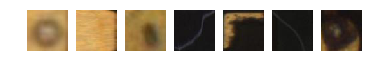

In [4]:
n_defect = len(defect_type_list) #total 7 type
samples_each_type = int(float(in_X.shape[0])/float(n_defect)) # 19 samples in each type

if True:
    for i in range(n_defect): 
        #face = faces.images[i]
        index=i*samples_each_type
        defect_img = in_X[index]
        subplot(1, n_defect, i + 1)
        imshow(defect_img.reshape((64, 64, 3)))#, cmap='gray')
        # imshow(face, cmap='gray')
        axis('off')

# images64 = faces.images.astype( np.float64 )
images64 = in_X.astype( np.float64 )
imsBase = images64.copy()
imsBaseHist = images64.copy() #Copy for histogram

## Data processing (Histogram equlization)
* Note:若影像資料夾為灰階,可試著將影像做Histogram equlization,當作另一條輸入.灰階影像時使用此方法有一定的幫助(proved by Jason Young), 但若影像為彩色(RGB)時,測試過將RGB三channel分別做Histogram equlization,並一併輸入時(加上原始影像共 6 channels)並無太大幫助.(proved by Sophie)

* About histogram equlization:
 - https://zh.wikipedia.org/wiki/%E7%9B%B4%E6%96%B9%E5%9B%BE%E5%9D%87%E8%A1%A1%E5%8C%96
 - https://cg2010studio.com/2012/11/12/opencv-histogram-equalization-%E7%9B%B4%E6%96%B9%E5%9C%96%E5%9D%87%E8%A1%A1%E5%8C%96/

/home/d500dl/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


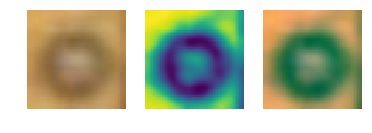

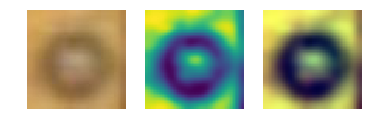

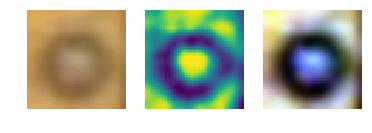

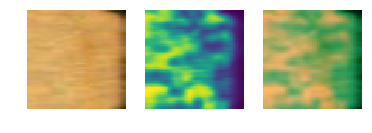

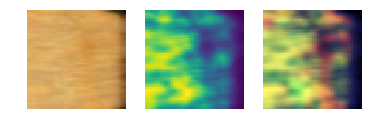

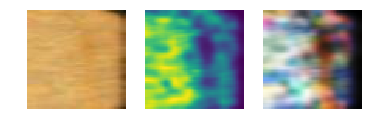

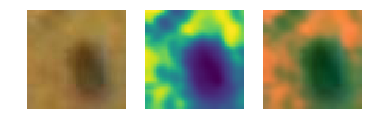

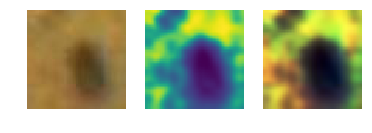

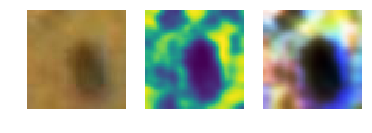

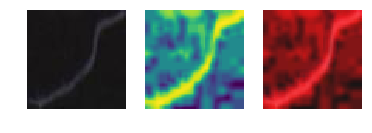

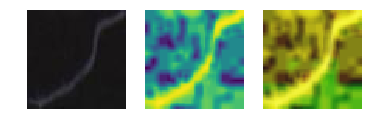

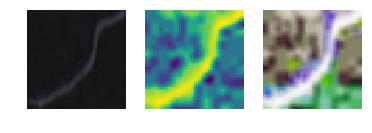

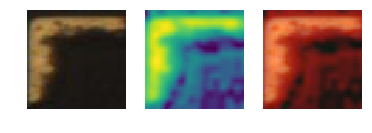

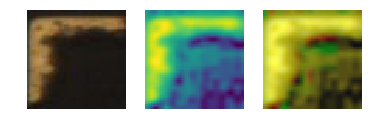

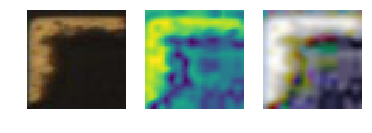

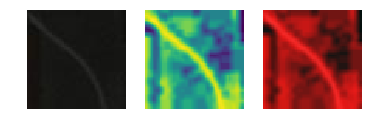

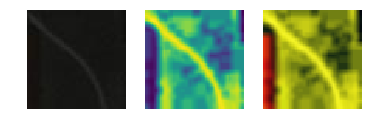

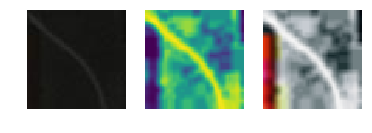

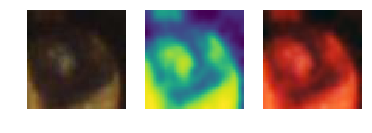

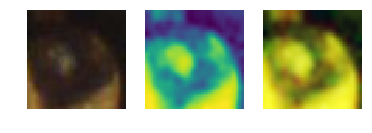

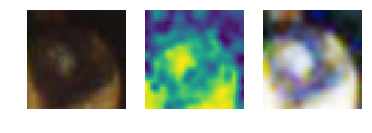

In [5]:
if True:
    for i in range(len(images64)):
        for j in range(3):
            '''
            im_orig = images64[i,:,:,j]
            im_local_mean = ndimage.uniform_filter(im_orig, size=8)
            imsBase[i,:,:,j] = im_orig - im_local_mean
            '''
            imsBaseHist[i,:,:,j] = exposure.equalize_hist(imsBase[i,:,:,j])

            im_orig = imsBaseHist[i,:,:,j]
            imsBaseHist[i,:,:,j] = ndimage.uniform_filter(im_orig, size=5)
            
            if True and (float(i)%float(samples_each_type) == 0):
                fig = plt.figure()#figsize=(3,1))
                #plt.gray()  # show the filtered result in grayscale
                p1 = fig.add_subplot(131)  # left side
                p2 = fig.add_subplot(132)  # middle part
                p3 = fig.add_subplot(133)  # right side
                [ p.axis('off') for p in (p1, p2, p3) ]
                '''
                p1.imshow(im_orig)
                p2.imshow(im_local_mean)
                p3.imshow(imsBase[i])
                '''
                p1.imshow(images64[i])
                p2.imshow(im_orig)
                p3.imshow(imsBaseHist[i])

Actually...I have no idea what these two cells are doing for(It's written by Jason)..So I just skip them Orz

In [6]:
if False:
    # - Now imsBase: original images less local mean
    # - If "axis = 0" omitted, the answer becomes a single (i.e. 1X1) value.
    im_global_mean = np.mean( imsBase, axis = 0 )
    # im_global_mean = np.mean( imsBase[:300,:,:], axis = 0 )
    # print im_global_mean.shape
    # (64, 64)
    # print type( im_global_mean[0,0] )
    # <type 'numpy.float32'>
    # print im_global_mean[0, :4]
    # [-0.06994512 -0.04040129 -0.01217329  0.00733148]

    if False:
        subplot(1, 1, 1)
        imshow(im_global_mean, cmap='gray')

    imsBase = imsBase - im_global_mean
    # - Now imsBase: original images less local & global mean

    if True:
        # - To verify that the global mean now is indeed 0-image.
        im_global_mean = np.mean( imsBase, axis = 0 )
        print(im_global_mean[0, :4])
        # [ -1.56462188e-09   8.90344420e-09  -7.39470130e-09   5.17815346e-09]
        print(im_global_mean.max(), im_global_mean.min())
        # 9.52929e-08 -9.0003e-08
        if False:
            subplot(1, 1, 1)
            imshow(im_global_mean, cmap='gray')
            # Although it does not look like 0-image, it is indeed 0-image.


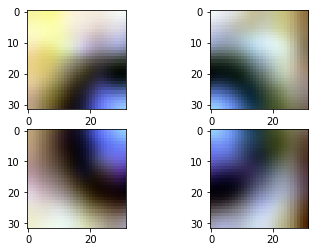

In [7]:
if True:
    fig = plt.figure()
    #plt.gray()  # show the filtered result in grayscale
    p1 = fig.add_subplot(221)
    p2 = fig.add_subplot(222)
    p3 = fig.add_subplot(223)
    p4 = fig.add_subplot(224)
    p1.imshow(imsBaseHist[0, :32, :32])
    p2.imshow(imsBaseHist[0, :32, 32:])
    p3.imshow(imsBaseHist[0, 32:, :32])
    p4.imshow(imsBaseHist[0, 32:, 32:])

## Define global variables with ASE dataset

In [8]:
#n_person = len(defect_type_list) #7 # total defect type
#n_total_per_person = 19 # number of samples per type

n_train_per_type = int(n_train_user) # number of samples for training
n_test_per_type = samples_each_type - n_train_per_type # number of samples for training

n_total_images = n_defect * samples_each_type
n_train_images = n_defect * n_train_per_type
n_test_images  = n_defect * n_test_per_type

## Parse training and testing set
- If there are 19 samples for each type, and the parse number(n_train_user) is 13(dafault), it means 13 samples for training set and 6(=19-13) samples for testing.
- n_retained: the number of features you want to "keep" in the end of each PCA layer. The max value is "total training images - 1"(because of the dimension), or you can define yourself.

In [9]:
#listTrain = [ i for i in range(n_total_images) if i % 10 < n_train_per_type ]
#listTest  = [ i for i in range(n_total_images) if i % 10 >= n_train_per_type ]
listTrain = [ i for i in range(n_total_images) if i % samples_each_type < n_train_per_type ]
listTest  = [ i for i in range(n_total_images) if i % samples_each_type >= n_train_per_type ]

print('listTrain index:\n',listTrain)
print('\nlistTest:\n', listTest)
print('\n------------\n')

imsTrain = imsBase[ listTrain,:,: ]
imsTest  = imsBase[ listTest, :,: ]
imsTrainHist = imsBaseHist[ listTrain,:,: ]
imsTestHist  = imsBaseHist[ listTest, :,: ]

n_retained = min( n_total_images, n_train_images - 1 ) 
#n_retained = min( 64, n_train_images - 1 ) 
print('Total', n_total_images) #, n_train_images - 1)
print('keep ', n_retained)

listTrain index:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]

listTest:
 [13, 14, 15, 16, 17, 18, 32, 33, 34, 35, 36, 37, 51, 52, 53, 54, 55, 56, 70, 71, 72, 73, 74, 75, 89, 90, 91, 92, 93, 94, 108, 109, 110, 111, 112, 113, 127, 128, 129, 130, 131, 132]

------------

Total 133
keep  90


## Get input data for each PCA layer

- 取前一級之output data作為本級之input data,若有需擴增則設n_double_dim_priorStage為2,將對前一級資料進行relu後,緊接在前一級資料後.

In [10]:
def get_inputDataSet( row, col, PCAs_priorStage, inputDataSets_priorStage, n_double_dim_priorStage ):
    if PCAs_priorStage is None:
        return inputDataSets_priorStage[ row, col ]
    else:
        r0 = row * 2
        c0 = col * 2
        dataList = []
        for r, c in ((r0, c0), (r0, c0+1), (r0+1, c0), (r0+1, c0+1)):
            pca = PCAs_priorStage[r][c]
            dataSet = pca.transform( inputDataSets_priorStage[r,c] )
            dataList.append( dataSet ) 
            #dataList.append( - np.minimum( dataSet, 0 ) ) # - ReLu
            if n_double_dim_priorStage == 2:
                dataList.append( np.maximum( dataSet, 0 ) ) # ReLu
                # dataList.append( np.maximum( dataSet, 0 ) / 2.5 ) # ReLu
                # dataList.append( dataSet )
                # dataList.append( np.zeros_like( dataSet ) )
                # dataList.append( dataSet * 1.5 )
        inputDataSet = np.concatenate( dataList, axis = 1 )
        print('--',inputDataSet.shape)
        return inputDataSet

#  TRAINING  START  

## Stage 0

- 準備階段,將input data準備好匯入Saak中. 將input image以8x8x3個pixel切割圖片, 故一張 64x64x3 的image會被切出 8x8 個小圖 
- 所以inputDataSetsTrain0之shape為(8,8,91,192),其中：
 * 91 = training samples
 * 192 = 8x8x3 pixes per 小圖

In [11]:
#lengthInputData0 = 8 * 8 * 2
lengthInputData0 = 8 * 8 * 3
PCAs0 = None
inputDataSetsTrain0 = np.zeros(( 8, 8, n_train_images, lengthInputData0 )) 
for row in range(8):
    for col in range(8):
        """
        inputDataSetsTrain0[row,col] = np.concatenate( (
                imsTrain[:,8*row:8*row+8,8*col:8*col+8,:].reshape(n_train_images,-1),
            imsTrainHist[:,8*row:8*row+8,8*col:8*col+8,:].reshape(n_train_images,-1)), axis = 1)
        """
        inputDataSetsTrain0[row,col] = imsTrain[:,8*row:8*row+8,8*col:8*col+8,:].reshape(n_train_images,-1)
print('*0',inputDataSetsTrain0[row, col].shape)        

n_double_dim0 = 0 

*0 (91, 192)


## Stage 1: starting from 8 pixels X 8 pixels 

- stage 1: spatial 8X8
- 因此為第1層,未有前一層的PCA(PCAs0=None),故直接以input data(normalize後)訓練此層PCA(PCAs8)

In [12]:
lengthInputData8 = 8 * 8 * 3
retained8 = min( n_retained, lengthInputData8 )
print('@stage1:', n_retained, lengthInputData8,  ', keep', retained8)
inputDataSetsTrain8 = np.zeros(( 8, 8, n_train_images, lengthInputData8 ))
mean8 = np.zeros(( 8, 8, lengthInputData8 )) 
PCAs8 = [] # PCAs8[i][j]
for row in range(8):
    PCAs_row = []
    for col in range(8):
        inputDataSetsTrain8[ row, col ] = get_inputDataSet( row, col, PCAs0, inputDataSetsTrain0, n_double_dim0 )
        mean8[ row, col ] = np.mean( inputDataSetsTrain8[ row, col ], axis = 0 )
        inputDataSetsTrain8[ row, col ] -= mean8[ row, col ]

        pca = PCA( n_components=retained8 ).fit( inputDataSetsTrain8[ row, col ] )
        PCAs_row.append( pca )
    PCAs8.append( PCAs_row )

PCAs8_array=np.asarray(PCAs8)
print('*1', inputDataSetsTrain8[row, col].shape)
print(PCAs8_array.shape)

@stage1: 90 192 , keep 90
*1 (91, 192)
(8, 8)


## Stage 2: spatial 4X4

第2層,輸入前一層的output,此層是將前一層輸出切成4x4張小圖,每個小圖原始input加上relu後,保留4x90x2個點,當成此層的輸入,train此層的PCA(PCAs4)

In [13]:
n_double_dim8 = 2 
lengthInputData4 = 4 * retained8 * n_double_dim8
retained4 = min( n_retained, lengthInputData4 )
print('@stage2:', n_retained, lengthInputData4,  ', keep', retained4)
inputDataSetsTrain4 = np.zeros(( 4, 4, n_train_images, lengthInputData4 ))
mean4 = np.zeros(( 4, 4, lengthInputData4 )) 
PCAs4 = [] # PCAs4[i][j]
for row in range(4):
    PCAs_row = []
    for col in range(4):
        inputDataSetsTrain4[ row, col ] = get_inputDataSet( row, col, PCAs8, inputDataSetsTrain8, n_double_dim8 )
        mean4[ row, col ] = np.mean( inputDataSetsTrain4[ row, col ], axis = 0 )
        inputDataSetsTrain4[ row, col ] -= mean4[ row, col ]

        pca = PCA( n_components=retained4 ).fit( inputDataSetsTrain4[ row, col ] )
        PCAs_row.append( pca )
    PCAs4.append( PCAs_row )
    
PCAs4_array=np.asarray(PCAs4)
print('*2', inputDataSetsTrain4[row, col].shape)
print(PCAs4_array.shape)

@stage2: 90 720 , keep 90
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
*2 (91, 720)
(4, 4)


## Stage 3: spatial 2X2

第3層,輸入前一層的output,此層是將前一層輸出切成2x2張小圖,每個小圖原始input加上relu後,保留4x90x2個點,當成此層的輸入,train此層的PCA(PCAs2)

In [14]:
n_double_dim4 = 2
lengthInputData2 = 4 * retained4 * n_double_dim4 
retained2 = min( n_retained, lengthInputData2 )
print('@stage3:', n_retained, lengthInputData2,  ', keep', retained2)
inputDataSetsTrain2 = np.zeros(( 2, 2, n_train_images, lengthInputData2 ))
mean2 = np.zeros(( 2, 2, lengthInputData2 )) 
PCAs2 = [] # PCAs2[i][j]
for row in range(2):
    PCAs_row = []
    for col in range(2):
        inputDataSetsTrain2[ row, col ] = get_inputDataSet( row, col, PCAs4, inputDataSetsTrain4, n_double_dim4 )
        mean2[ row, col ] = np.mean( inputDataSetsTrain2[ row, col ], axis = 0 )
        inputDataSetsTrain2[ row, col ] -= mean2[ row, col ]

        pca = PCA( n_components=retained2 ).fit( inputDataSetsTrain2[ row, col ] )
        PCAs_row.append( pca )
    PCAs2.append( PCAs_row )

PCAs2_array=np.asarray(PCAs2)
print('*3', inputDataSetsTrain2[row, col].shape)
print(PCAs2_array.shape)

@stage3: 90 720 , keep 90
-- (91, 720)
-- (91, 720)
-- (91, 720)
-- (91, 720)
*3 (91, 720)
(2, 2)


## Stage 4: spatial 1X1

第4層,輸入前一層的output,此層是將前一層輸出切成1x1張小圖,每個小圖原始input加上relu後,保留4x90x2個點,當成此層的輸入,train此層的PCA(PCAs1)

In [15]:
n_double_dim2 = 2
lengthInputData1 = 4 * retained2 * n_double_dim2 
retained1 = min( n_retained, lengthInputData1 )
print('@stage4:', n_retained, lengthInputData1,  ', keep', retained1)
inputDataSetsTrain1 = np.zeros(( 1, 1, n_train_images, lengthInputData1 ))
mean1 = np.zeros(( 1, 1, lengthInputData1 )) 
PCAs1 = [] # PCAs1[i][j]
for row in range(1):
    PCAs_row = []
    for col in range(1):
        inputDataSetsTrain1[ row, col ] = get_inputDataSet( row, col, PCAs2, inputDataSetsTrain2, n_double_dim2 )
        mean1[ row, col ] = np.mean( inputDataSetsTrain1[ row, col ], axis = 0 )
        inputDataSetsTrain1[ row, col ] -= mean1[ row, col ]

        pca = PCA( n_components=retained1,whiten=True ).fit( inputDataSetsTrain1[ row, col ] )
        PCAs_row.append( pca )
    PCAs1.append( PCAs_row )

print('*4', inputDataSetsTrain1[row, col].shape)

@stage4: 90 720 , keep 90
-- (91, 720)
*4 (91, 720)


## Final: feature space

輸出前一層output後,進入SVM做分類辨識

In [16]:
n_double_dim1 = 0
pca = PCAs1[0][0]
X = pca.transform( inputDataSetsTrain1[0,0] ) 
# print X[0]
print('Stage4 output:', X.shape)
# (160, 159)
# print pca.explained_variance_
#y = faces.target[ listTrain ]
y = in_y[ listTrain ]
#clf = SVC(gamma=0.00001)
clf = SVC(kernel='linear')
# clf = SVC(decision_function_shape='ovo', kernel='linear')
clf.fit(X, y) 

#print(type(y[0]))

print('------------')
print('Each person:', n_train_per_type, 'training images,', n_test_per_type, 'test images')

Stage4 output: (91, 90)
------------
Each person: 13 training images, 6 test images


#  TESTING START 

In [17]:
inputDataSetsTest0 = np.zeros(( 8, 8, n_test_images, lengthInputData0 )) 
for row in range(8):
    for col in range(8):
        """
        inputDataSetsTest0[row,col] = np.concatenate( (
                imsTest[:,8*row:8*row+8,8*col:8*col+8,:].reshape(n_test_images,-1),
            imsTestHist[:,8*row:8*row+8,8*col:8*col+8,:].reshape(n_test_images,-1)), axis = 1) 
        """
        inputDataSetsTest0[row,col] = imsTest[:,8*row:8*row+8,8*col:8*col+8,:].reshape(n_test_images,-1)

## Stage 1: spatial 8X8

In [18]:
inputDataSetsTest8 = np.zeros(( 8, 8, n_test_images, lengthInputData8 )) 
for row in range(8):
    for col in range(8):
        inputDataSetsTest8[row,col] = get_inputDataSet(row,col,PCAs0,inputDataSetsTest0,n_double_dim0) - mean8[row,col]

## Stage 2: spatial 4X4

In [19]:
inputDataSetsTest4 = np.zeros(( 4, 4, n_test_images, lengthInputData4 ))
for row in range(4):
    for col in range(4):
        inputDataSetsTest4[row,col] = get_inputDataSet(row,col,PCAs8,inputDataSetsTest8,n_double_dim8) - mean4[row,col]


-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)


## Stage 3: spatial 2X2

In [20]:
inputDataSetsTest2 = np.zeros(( 2, 2, n_test_images, lengthInputData2 ))
for row in range(2):
    for col in range(2):
        inputDataSetsTest2[row,col] = get_inputDataSet(row,col,PCAs4,inputDataSetsTest4,n_double_dim4) - mean2[row,col]

-- (42, 720)
-- (42, 720)
-- (42, 720)
-- (42, 720)


## Stage 4: spatial 1X1

In [21]:
inputDataSetsTest1 = np.zeros(( 1, 1, n_test_images, lengthInputData1 ))
for row in range(1):
    for col in range(1):
        inputDataSetsTest1[row,col] = get_inputDataSet(row,col,PCAs2,inputDataSetsTest2,n_double_dim2) - mean1[row,col]

-- (42, 720)


## Final: feature space

In [22]:
pca = PCAs1[0][0]
X = pca.transform( inputDataSetsTest1[0,0] ) 
#y = faces.target[ listTest ]
y = in_y[ listTest ]

## Prediction using TEST images

In [23]:
if True:
    predictX = clf.predict(X)

    wrong = 0
    for i in range( len( predictX ) ):
        if predictX[i] != y[i]:
            wrong += 1
            if False:
                subplot(1, 1, 1)
                imshow(imsTest[i], cmap='gray')

    print('use TEST images, accuracy:', ( n_test_images - wrong ) / float( n_test_images ), \
            ', wrong:', wrong, ', total:', n_test_images )
    ###print(( n_test_images - wrong ) / float( n_test_images ), wrong, n_test_images)



use TEST images, accuracy: 0.6428571428571429 , wrong: 15 , total: 42


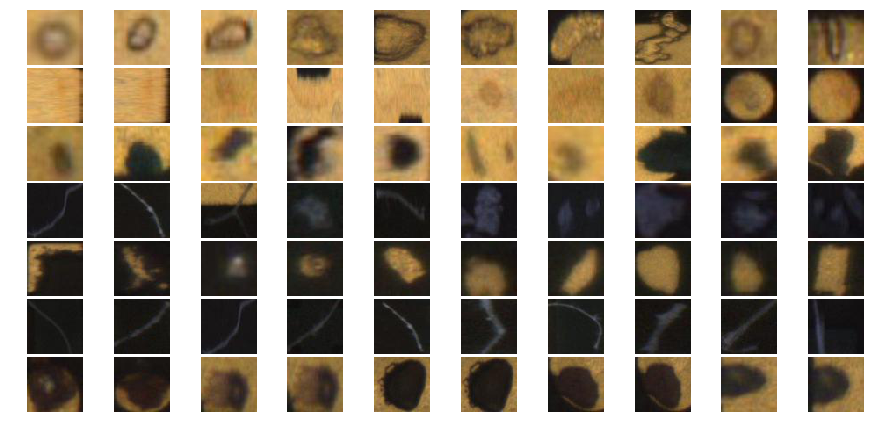

In [24]:
if True:
    ## imsPlot = faces.images
    imsPlot = in_X
    # imsPlot = imsBase[:200]
    # imsPlot = imsBase
    # imsPlot = imsBaseHist
    
    fig = plt.figure(figsize=(12, 12))
    # fig = plt.figure(figsize=(9, 9))
    # fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    n_pictures = min(150,len(imsPlot))
    j=0
    for i in range(n_pictures):
        if float(i)%float(samples_each_type) < 10:
            # - plot the images in a matrix of 20x20
            # p = fig.add_subplot(20, 20, i + 1)
            j+=1
            p = fig.add_subplot(15, 10, j)
            p.imshow(imsPlot[i], cmap=plt.cm.bone)
            # - label the image with the target value
            # p.text(0, 14, "smiling")
            # p.text(0, 60, str(i))

        else:
            pass
        p.axis('off')